# Practical Portfolio Optimization

A personal project explorinng risk-return trade-offs in portfolio management using Python. This notebook focuses on constructing the efficient frontier using the Markowitz mean-variance optimization technique.

Note: This project began as a personal tool to understand and apply portfolio optimization to my own investment strategies. I do not plan to short assets or use leverage. The focus is on long-only portfolios with a maximum weight of 1 for each asset.

```python

## 1. Efficient Frontier

The efficient frontier is a key concept in modern portfolio theory that represents the set of optimal portfolios offering the highest expected return for a given level of risk, or the lowest risk for a given level of expected return.

### Mathematical Foundation

The efficient frontier is derived by solving a series of optimization problems:
- Minimize portfolio variance (risk) subject to a target return constraint
- Alternatively, maximize return subject to a risk constraint

### Interpretation

- **Points below the frontier**: Suboptimal portfolios (same risk, lower return or same return, higher risk)
- **Points above the frontier**: Theoretically impossible to achieve consistently without additional risk factors

### Application

By identifying the efficient frontier, investors can:
1. Choose the optimal portfolio based on their risk tolerance
2. Avoid inefficient portfolios that don't maximize return for a given risk level
3. Understand the trade-offs between risk and return in their investment decisions



## 2. Sharpe Ratio

The Sharpe ratio is a measure that helps investors evaluate the risk-adjusted performance of an investment or portfolio. It calculates the excess return (or risk premium) per unit of risk.

#### Formula
The Sharpe ratio is calculated as:

$$\text{Sharpe Ratio} = \frac{R_p - R_f}{\sigma_p}$$

Where:
- $R_p$ = Expected portfolio return
- $R_f$ = Risk-free rate
- $\sigma_p$ = Portfolio standard deviation (volatility)

#### Interpretation

- **Higher is better**: A higher Sharpe ratio indicates better risk-adjusted performance
- **Benchmark**: Typically, a Sharpe ratio greater than 1.0 is considered acceptable
- **Investment comparison**: Allows comparison between different investments with different risk profiles
- **Efficient frontier**: The maximum Sharpe ratio portfolio is the point on the efficient frontier where the capital market line (drawn from the risk-free rate) is tangent to the efficient frontier

#### Limitations

- Assumes returns are normally distributed
- Uses standard deviation as the risk measure, which treats upside and downside volatility equally
- Based on historical data, which may not predict future performance
- Most useful when comparing similar investment strategies

In our portfolio optimization, we use the Sharpe ratio to identify the optimal portfolio that provides the best balance between expected return and risk.

In [1]:
import sys
import os
import importlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Add the parent directory to Python path so we can import from src
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))))

In [2]:
tickers = ['AAPL','GOOG','AMZN', "META"]

# Load the data_loader module
if 'portfolio_data' not in globals():
    import src.data_loader
    importlib.reload(src.data_loader)
    from src.data_loader import get_portfolio_data
    portfolio_data = get_portfolio_data(tickers)  # Load data for the first time
else:
    # Use cached data
    print("Using cached portfolio_data")
    from src.data_loader import get_portfolio_data
    print("portfolio_data already loaded, skipping data loading step")


Risk-free rate fetched: 0.0418 (4.18%)
Fetching sector data for each ticker...
Sector data fetched for 4 tickers
Successfully downloaded data for: ['AAPL', 'AMZN', 'GOOG', 'META']


In [3]:
# How to access sector data from portfolio_data
print("SECTOR ANALYSIS FROM PORTFOLIO DATA:")
print("=" * 50)

if portfolio_data and 'sectors' in portfolio_data and portfolio_data['sectors']:
    sectors_data = portfolio_data['sectors']
    
    print(f"Portfolio contains {len(sectors_data)} assets:")
    print()
    
    # Display sector information
    for ticker, info in sectors_data.items():
        print(f"{ticker} ({info['company_name']})")
        print(f"   Sector: {info['sector']}")
        print(f"   Industry: {info['industry']}")
        print()
    
    # Analyze sector diversification
    print("SECTOR DIVERSIFICATION ANALYSIS:")
    print("-" * 40)
    
    # Count by sector
    sector_counts = {}
    for info in sectors_data.values():
        sector = info['sector']
        sector_counts[sector] = sector_counts.get(sector, 0) + 1
    
    for sector, count in sector_counts.items():
        percentage = count / len(sectors_data) * 100
        print(f"{sector}: {count} assets ({percentage:.1f}%)")
    
    # Diversification score (lower is more diversified)
    diversification_score = len(sector_counts) / len(sectors_data)
    print(f"\nDiversification Score: {diversification_score:.2f}")
    print(f"(1.0 = perfectly diversified, lower = more concentrated)")
    
    if diversification_score < 0.5:
        print("Portfolio is concentrated in few sectors - consider more diversification")
    elif diversification_score > 0.8:
        print("Portfolio is well diversified across sectors")
    else:
        print("Portfolio has moderate sector diversification")
        
else:
    print("No sector data available in portfolio_data")
    print("This could happen if:")
    print("• Sector data fetching failed")
    print("• portfolio_data wasn't loaded with the updated data_loader")
    print("• Network issues prevented fetching company info")

SECTOR ANALYSIS FROM PORTFOLIO DATA:
Portfolio contains 4 assets:

AAPL (Apple Inc.)
   Sector: Technology
   Industry: Consumer Electronics

GOOG (Alphabet Inc.)
   Sector: Communication Services
   Industry: Internet Content & Information

AMZN (Amazon.com, Inc.)
   Sector: Consumer Cyclical
   Industry: Internet Retail

META (Meta Platforms, Inc.)
   Sector: Communication Services
   Industry: Internet Content & Information

SECTOR DIVERSIFICATION ANALYSIS:
----------------------------------------
Technology: 1 assets (25.0%)
Communication Services: 2 assets (50.0%)
Consumer Cyclical: 1 assets (25.0%)

Diversification Score: 0.75
(1.0 = perfectly diversified, lower = more concentrated)
Portfolio has moderate sector diversification


## 3. Monte Carlo Simulation: Visualizing the portfolio landscape

In this section, we generate thousands of random portfolios by assigning random weights to a selection of assets. For each portfolio, we calculate:

- Expected return (annualized)
- Volatility (standard deviation, annualized)
- Sharpe ratio

This produces a "cloud" of portfolios in risk-return space, giving us an intuitive view of the potential risk-return trade-offs - but not what's optimal. The efficient frontier is not directly visible in this cloud, but it's embedded within the upper edge of the cloud.

```python

Generated 5000 random portfolios
Risk-free rate: 0.0418 (4.18%)
Returns range: 0.1392 to 0.3015
Volatilities range: 0.0670 to 0.1015
Maximum Sharpe-ratio: 2.8146


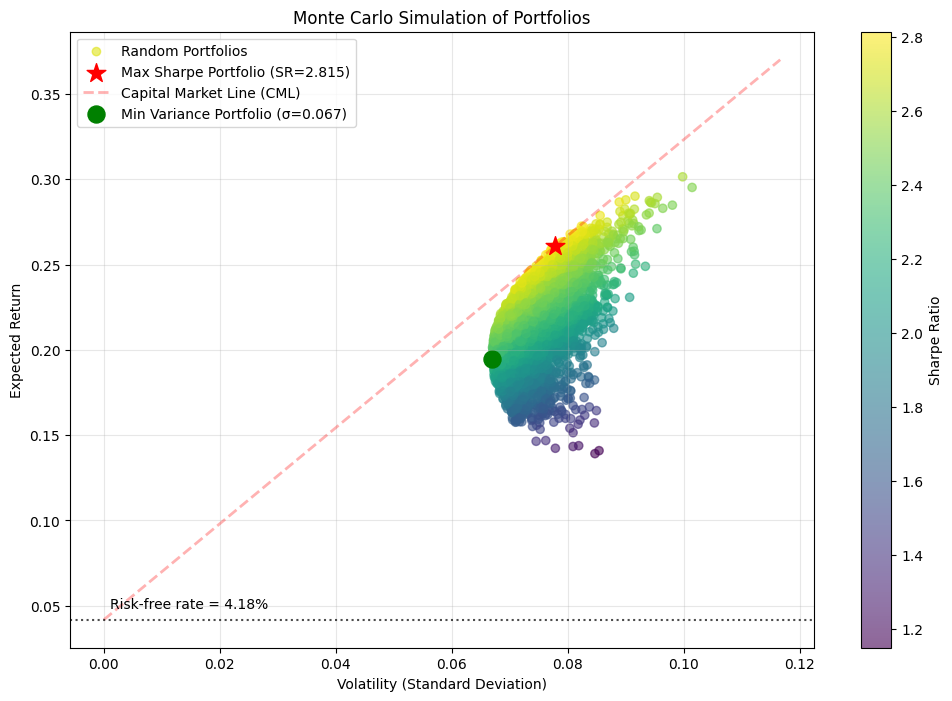


=== OPTIMAL PORTFOLIOS ===

1. Maximum Sharpe Ratio Portfolio (Monte Carlo)
   Sharpe Ratio: 2.8146
   Expected Return: 0.2607 (26.07%)
   Volatility: 0.0778 (7.78%)
   Asset Allocation:
   • AAPL: 12.92%
   • GOOG: 0.03%
   • AMZN: 48.71%
   • META: 38.33%


In [4]:
from src.optimizer import monte_carlo

N_MC = 5000
annualized_mean_returns = portfolio_data["stats"]["annualized_mean_returns"]
annualized_covariance = portfolio_data["annualized_covariance"]
risk_free_rate = portfolio_data["stats"]["risk_free_rate"]
weights_random_df, returns_random, volatilities_random = monte_carlo(N_MC, tickers, annualized_mean_returns, annualized_covariance)

sharpe = (returns_random - risk_free_rate) / volatilities_random
max_sharpe_index = np.argmax(sharpe)
max_sharpe_ratio = sharpe[max_sharpe_index]

# CML: Capital Market Line - tangent line from risk-free rate to optimal portfolio
sigma_range = np.linspace(0, volatilities_random[max_sharpe_index] * 1.5, 100)
cml = risk_free_rate + max_sharpe_ratio * sigma_range

print(f"Generated {N_MC} random portfolios")
print(f"Risk-free rate: {risk_free_rate:.4f} ({risk_free_rate*100:.2f}%)")
print(f"Returns range: {returns_random.min():.4f} to {returns_random.max():.4f}")
print(f"Volatilities range: {volatilities_random.min():.4f} to {volatilities_random.max():.4f}")
print(f"Maximum Sharpe-ratio: {max_sharpe_ratio:.4f}")


# Plotting the results
plt.figure(figsize=(12,8))
# Scatter plot of random portfolios
plt.scatter(volatilities_random, returns_random, c=sharpe, cmap='viridis', alpha=0.6, label="Random Portfolios")
plt.colorbar(label='Sharpe Ratio')
# Highlight the maximum Sharpe ratio portfolio
plt.scatter(volatilities_random[max_sharpe_index], returns_random[max_sharpe_index], 
           color="red", marker='*', s=200, label=f"Max Sharpe Portfolio (SR={max_sharpe_ratio:.3f})")
# Plot the Capital Market Line (CML)
plt.plot(sigma_range, cml, color='red', linestyle='--', alpha=0.3, linewidth=2, label="Capital Market Line (CML)")
# Annotate the risk-free rate on the y-axis
plt.axhline(y=risk_free_rate, color='black', linestyle=':', alpha=0.7)
plt.text(0.001, risk_free_rate+0.005, f"Risk-free rate = {risk_free_rate:.2%}", 
         fontsize=10, va='bottom', ha='left')
# Add minimum variance portfolio
min_vol_idx = np.argmin(volatilities_random)
plt.scatter(volatilities_random[min_vol_idx], returns_random[min_vol_idx],
            color='green', marker='o', s=150, 
            label=f"Min Variance Portfolio (σ={volatilities_random[min_vol_idx]:.3f})")
plt.title("Monte Carlo Simulation of Portfolios")
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


# Get the weights of the portfolio with maximum Sharpe ratio
optimal_random_portfolio = weights_random_df.iloc[max_sharpe_index].map(lambda x: f"{x*100:.2f}%")
print("\n=== OPTIMAL PORTFOLIOS ===")
print("\n1. Maximum Sharpe Ratio Portfolio (Monte Carlo)")
print(f"   Sharpe Ratio: {sharpe[max_sharpe_index]:.4f}")
print(f"   Expected Return: {returns_random[max_sharpe_index]:.4f} ({returns_random[max_sharpe_index]*100:.2f}%)")
print(f"   Volatility: {volatilities_random[max_sharpe_index]:.4f} ({volatilities_random[max_sharpe_index]*100:.2f}%)")
print("   Asset Allocation:")
for ticker, weight in optimal_random_portfolio.items():
    print(f"   • {ticker}: {weight}")

The dense cloud reflects feasible long-only portfolios. The max Sharpe portfolio lies near the upper edge of the cloud, and the Capital Market Line (CML) tangents the frontier at this point. 

## 4. Analytical Mean-Variance Optimization (Markowitz)

We now derive the efficient frontier analytically using the Markowitz mean-variance optimization framework. This involves solving a constrained quadratic optimization problem with Lagrange multipliers to find the optimal portfolio weights that minimize risk for a given level of expected return, or maximize return for a given level of risk.

#### Mathematical Formulation

1. **Objective Function**: Minimize portfolio variance
    $$\min_w \sigma_p^2 = \mathbf{w}^T \Sigma \mathbf{w}$$

2. **Constraints**:
    - Portfolio weights sum to 1: $\sum_{i=1}^n w_i = 1$
    - Target return is achieved: $\mathbf{w}^T \mathbf{\mu} = r_{target}$

3. **Lagrangian Function**:
    $$L(\mathbf{w}, \lambda_1, \lambda_2) = \mathbf{w}^T \Sigma \mathbf{w} - \lambda_1(\mathbf{w}^T \mathbf{\mu} - r_{target}) - \lambda_2(\sum_{i=1}^n w_i - 1)$$

While elegant and exact, this method assumes:
- Normally distributed returns
- No bounds (e.g., short-selling allowed, weights can be negative)
- No transaction costs or taxes
- Closed-form mathematical tractability

This gives us a smooth, idealized efficient frontier - but may not reflect real-world constraints or complexities.

```python

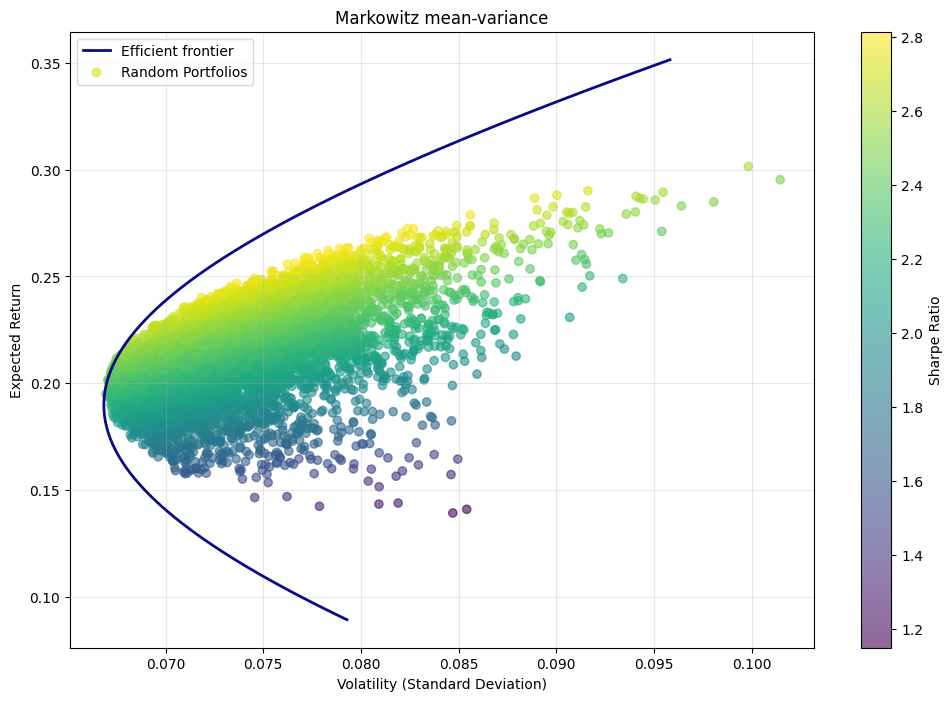

In [5]:
from src.optimizer import markowitz_mean_variance

desired_returns = np.linspace(returns_random.min() - 0.05, returns_random.max() + 0.05, 100)

portfolio_MW = []
for r in desired_returns:
    weights_MW, lagrange_multipliers = markowitz_mean_variance(annualized_covariance, annualized_mean_returns, r)

    volatility_MW = np.sqrt(np.dot(weights_MW.T, (np.dot(annualized_covariance, weights_MW))))

    portfolio_MW.append((r, volatility_MW))
r, volatility_MW = zip(*portfolio_MW)

plt.figure(figsize=(12,8))
plt.plot(volatility_MW, r, label = "Efficient frontier", color = "#0A0A88", linewidth=2)
plt.scatter(volatilities_random, returns_random, c=sharpe, cmap='viridis', alpha=0.6, label="Random Portfolios")
plt.colorbar(label='Sharpe Ratio')
plt.title("Markowitz mean-variance")
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

The analytical frontier extends beyond the cloud of random portfolios, especially at higher return levels. This illustrates how the model allows shorting and ignores realistic constraints, producing theoretically optimal but practically unattainable portfolios in many regions.

## 5. Numerical Optimization with SLSQP

To overcome the limitations of the analytical approach, we use numerical optimization with Sequential Least Squares Programming (SLSQP). This method allows us to:
- Enforce realistic constraints (e.g., no short-selling, weights sum to 1)
- Handle non-normally distributed returns
- Minimize volatility for a given target return (to find the efficient frontier)
- Maximize Sharpe ratio (to find the optimal portfolio)

This approach is more flexible and can yield portfolios that better reflect real-world conditions, but it may be computationally intensive and sensitive to initial conditions.

```python

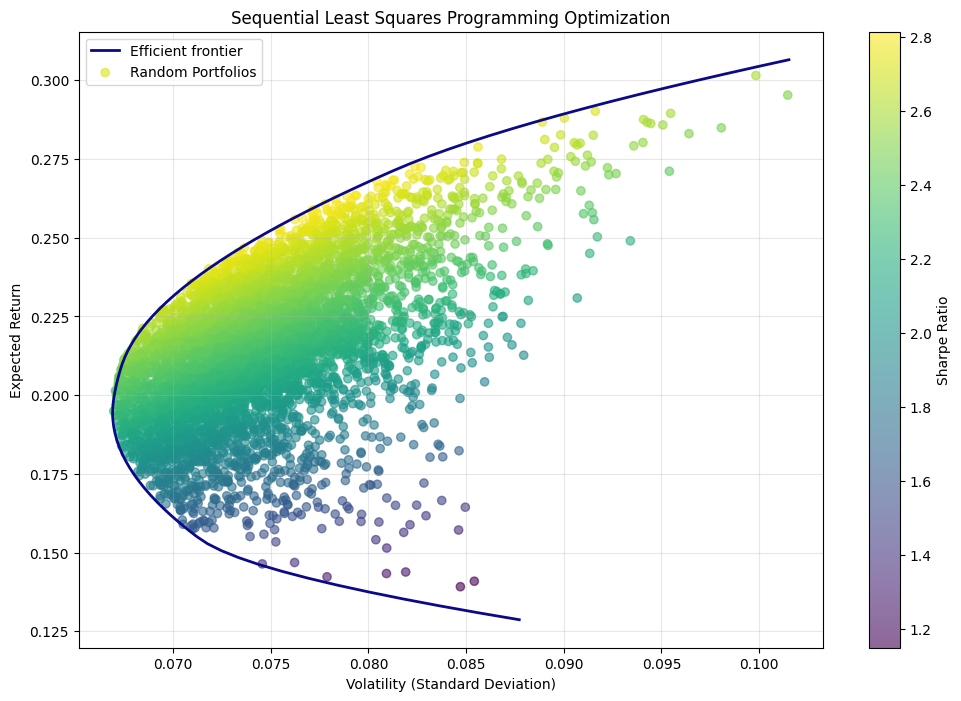

In [6]:
from src.optimizer import portfolio_minimize
from src.optimizer import portfolio_maximize_sharpe

desired_returns = np.linspace(returns_random.min()-0.05, returns_random.max() + 0.005, 100)
min_weight = 0.0

portfolio_SM_var = []
for r in desired_returns:
    result_SM_var = portfolio_minimize(annualized_mean_returns, annualized_covariance, r, min_weight)
    weights_SM_var = result_SM_var.x

    volatility_SM_var = np.sqrt(np.dot(weights_SM_var.T, (np.dot(annualized_covariance, weights_SM_var))))

    # If optimization succeeded, add the volatility to our list
    if result_SM_var['success']:
        portfolio_SM_var.append((r, volatility_SM_var))
    else:
        # If optimization failed, use NaN to indicate a gap in the frontier
        portfolio_SM_var.append((r, np.nan))
    
r, volatility_SM_var = zip(*portfolio_SM_var)

# Maximizing Sharpe-ratio
result_SM_sharpe = portfolio_maximize_sharpe(annualized_mean_returns, annualized_covariance, risk_free_rate, min_weight)
weights_SM_sharpe = result_SM_sharpe.x

return_SM_sharpe = weights_SM_sharpe @ annualized_mean_returns
volatility_SM_sharpe = np.sqrt(np.dot(weights_SM_sharpe.T, (np.dot(annualized_covariance, weights_SM_sharpe))))

plt.figure(figsize=(12,8))
plt.plot(volatility_SM_var, r, label = "Efficient frontier", color = "#0A0A88", linewidth=2)
plt.scatter(volatilities_random, returns_random, c=sharpe, cmap='viridis', alpha=0.6, label="Random Portfolios")
plt.colorbar(label='Sharpe Ratio')
plt.title("Sequential Least Squares Programming Optimization")
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


The numerical frontier hugs the top of the Monte Carlo cloud closely, particularly on the upper half. This suggests that the constrained optimizer is successfully finding the most efficient long-only portfolios, and that it aligns well with the true feasible set.

## 6. The effect of minimum weight constraints

Imposing minimum weight constraints (e.g., no asset can have a weight below 0.05) can significantly alter the efficient frontier. This is particularly relevant for investors who want to ensure diversification and avoid over-concentration in any single asset.
Below, we explore how such constraints affect the efficient frontier and the optimal portfolio selection.

```python


=== COMPARISON OF MINIMUM WEIGHT CONSTRAINTS ===

Minimum Weight: 0.00%
  Min Sharpe Ratio Portfolio:
    Return = 26.75%
    Volatility = 7.99%
    Sharpe Ratio = 2.82

Minimum Weight: 5.00%
  Min Sharpe Ratio Portfolio:
    Return = 25.91%
    Volatility = 7.87%
    Sharpe Ratio = 2.76

Minimum Weight: 10.00%
  Min Sharpe Ratio Portfolio:
    Return = 24.83%
    Volatility = 7.69%
    Sharpe Ratio = 2.68


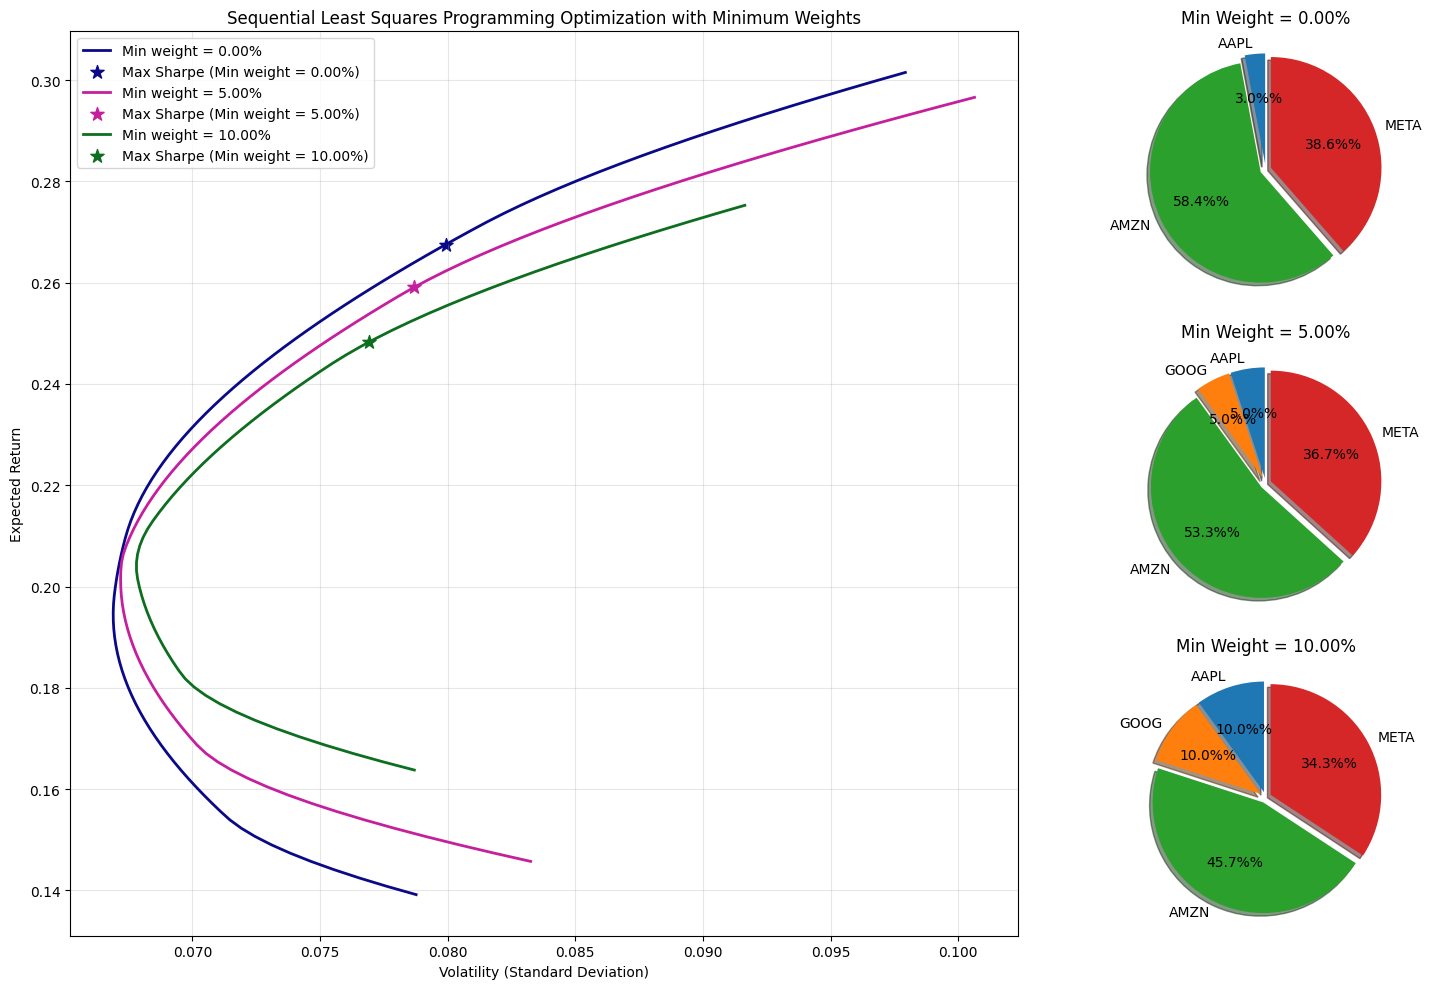

In [7]:
from src.optimizer import portfolio_minimize
from src.optimizer import portfolio_maximize_sharpe

desired_returns = np.linspace(returns_random.min(), returns_random.max(), 100)
volatilities_SM_var = []
returns_SM_sharpe = []
volatilities_SM_sharpe = []
weights_sharpe_list = []

min_weights = [0.0, 0.05, 0.10]

print("\n=== COMPARISON OF MINIMUM WEIGHT CONSTRAINTS ===")

for i, min_weight in enumerate(min_weights):

    portfolio_SM_var = []
    for r in desired_returns:
        result_SM_var = portfolio_minimize(annualized_mean_returns, annualized_covariance, r, min_weight = min_weight)
        weights_SM_var = result_SM_var.x

        volatility_SM_var = np.sqrt(np.dot(weights_SM_var.T, (np.dot(annualized_covariance, weights_SM_var))))

        # If optimization succeeded, add the volatility to our list
        if result_SM_var['success']:
            portfolio_SM_var.append((r, volatility_SM_var))
        else:
            # If optimization failed, use NaN to indicate a gap in the frontier
            portfolio_SM_var.append((r, np.nan))
        
    r, volatility_SM_var = zip(*portfolio_SM_var)

    # Minimizing Sharpe-ratio
    result_SM_sharpe = portfolio_maximize_sharpe(annualized_mean_returns, annualized_covariance, risk_free_rate, min_weight = min_weight)
    weights_SM_sharpe = result_SM_sharpe.x
    weights_sharpe_list.append(weights_SM_sharpe)

    return_SM_sharpe = weights_SM_sharpe @ annualized_mean_returns
    volatility_SM_sharpe = np.sqrt(np.dot(weights_SM_sharpe.T, (np.dot(annualized_covariance, weights_SM_sharpe))))

    # Append returns and volatilties to lists for later use when comparing
    if i == 0:
        volatilities_SM_var = [volatility_SM_var]
    else:
        volatilities_SM_var.append(volatility_SM_var)
    volatilities_SM_sharpe.append(volatility_SM_sharpe)
    returns_SM_sharpe.append(return_SM_sharpe)


    # Compare the results
    sharpe_ratio = (returns_SM_sharpe[i] - risk_free_rate) / volatilities_SM_sharpe[i]
    print(f"\nMinimum Weight: {min_weight:.2%}")
    print(f"  Min Sharpe Ratio Portfolio:")
    print(f"    Return = {returns_SM_sharpe[i]*100:.2f}%")
    print(f"    Volatility = {volatilities_SM_sharpe[i]*100:.2f}%")
    print(f"    Sharpe Ratio = {sharpe_ratio:.2f}")
        
# Plotting the results
fig = plt.figure(figsize=(20,10))
gs = gridspec.GridSpec(3, 4, figure = fig) # 3 rows, 4 columns

ax_big = fig.add_subplot(gs[:, :2])  # Big plot for efficient frontier
ax1 = fig.add_subplot(gs[0, 2])  # First subplot for min weight
ax2 = fig.add_subplot(gs[1, 2])  # Second subplot for min weight
ax3 = fig.add_subplot(gs[2, 2])  # Third subplot for min weight


colors = ['#0A0A88', "#C51F9E", "#0E6E1F"]  # Different colors for each min weight
for i in range(3):
    ax_big.plot(volatilities_SM_var[i], r, label=f"Min weight = {min_weights[i]:.2%}", linewidth=2, color=colors[i])
    ax_big.scatter(volatilities_SM_sharpe[i], returns_SM_sharpe[i], 
                color = colors[i], marker='*', s=100, label=f"Max Sharpe (Min weight = {min_weights[i]:.2%})")

    ax_big.set_xlabel('Volatility (Standard Deviation)')
    ax_big.set_ylabel('Expected Return')
    ax_big.set_title("Sequential Least Squares Programming Optimization with Minimum Weights")
    ax_big.legend()
    ax_big.grid(True, alpha=0.3)
# Create a better color palette
colors = plt.cm.tab10(np.arange(len(tickers)) % 10)

# Function to create labels that hide names for weights < 1%
def create_labels(weights, tickers):
    labels = []
    for i, (weight, ticker) in enumerate(zip(weights, tickers)):
        if weight >= 0.01:  # 1% threshold
            labels.append(ticker)
        else:
            labels.append('')  # Empty label for small weights
    return labels

# Function to create percentage labels that hide percentages for weights < 1%
def create_autopct(weights):
    def autopct_func(pct):
        # Find the corresponding weight for this percentage
        weight = pct / 100.0
        if weight >= 0.01:  # 1% threshold
            return f'{pct:.1f}%%'
        else:
            return ''  # Empty percentage for small weights
    return autopct_func

# Create pie charts for each minimum weight constraint
labels_0 = create_labels(weights_sharpe_list[0], tickers)
ax1.pie(weights_sharpe_list[0], labels=labels_0, autopct=create_autopct(weights_sharpe_list[0]), 
        startangle=90, colors=colors, shadow=True, explode=[0.05]*len(tickers))
ax1.set_title(f'Min Weight = {min_weights[0]:.2%}')

labels_1 = create_labels(weights_sharpe_list[1], tickers)
ax2.pie(weights_sharpe_list[1], labels=labels_1, autopct=create_autopct(weights_sharpe_list[1]), 
        startangle=90, colors=colors, shadow=True, explode=[0.05]*len(tickers))
ax2.set_title(f'Min Weight = {min_weights[1]:.2%}')

labels_2 = create_labels(weights_sharpe_list[2], tickers)
ax3.pie(weights_sharpe_list[2], labels=labels_2, autopct=create_autopct(weights_sharpe_list[2]), 
        startangle=90, colors=colors, shadow=True, explode=[0.05]*len(tickers))
ax3.set_title(f'Min Weight = {min_weights[2]:.2%}')
plt.tight_layout()
plt.show()

As we increase the minimum allowable weight for each asset, the shape of the efficient frontier changes noticeably.
- The frontier becomes narrower and flatter, meaning both the return range and volatility range shrink.
- The maximum Sharpe ratio slightly decreases with higher minimum weights, suggesting that the optimizer loses flexibility to find the most efficient risk-adjusted portfolio.

At first glance, the vertical "squishing" of the frontier might seem like it only limits return potential. However, the results show that the entire frontier shifts inward — we also lose access to lower-risk portfolios. This confirms that the constraint isn't just cutting off high-return outliers — it's compressing the full feasible set.

This is expected: by forcing the optimizer to allocate at least e.g. 10% to every asset, we reduce its ability to:
- Avoid underperformers
- Concentrate in high-return, low-volatility combinations

In summary, raising the minimum allocation constraint reduces the optimizer's degrees of freedom, leading to a more diversified but less efficient frontier overall.

## 7. The effect of maximum weight constraints

Imposing maximum weight constraints (e.g., no asset can have a weight above 0.5) can also significantly alter the efficient frontier. This is particularly relevant for investors who want to avoid over-concentration in any single asset and ensure diversification.
```python


=== COMPARISON OF MAXIMUM WEIGHT CONSTRAINTS ===

Maximum Weight: 100.00%
  Max Sharpe Ratio Portfolio:
    Return = 26.75%
    Volatility = 7.99%
    Sharpe Ratio = 2.82

Maximum Weight: 50.00%
  Max Sharpe Ratio Portfolio:
    Return = 26.57%
    Volatility = 7.95%
    Sharpe Ratio = 2.82

Maximum Weight: 40.00%
  Max Sharpe Ratio Portfolio:
    Return = 25.74%
    Volatility = 7.72%
    Sharpe Ratio = 2.79


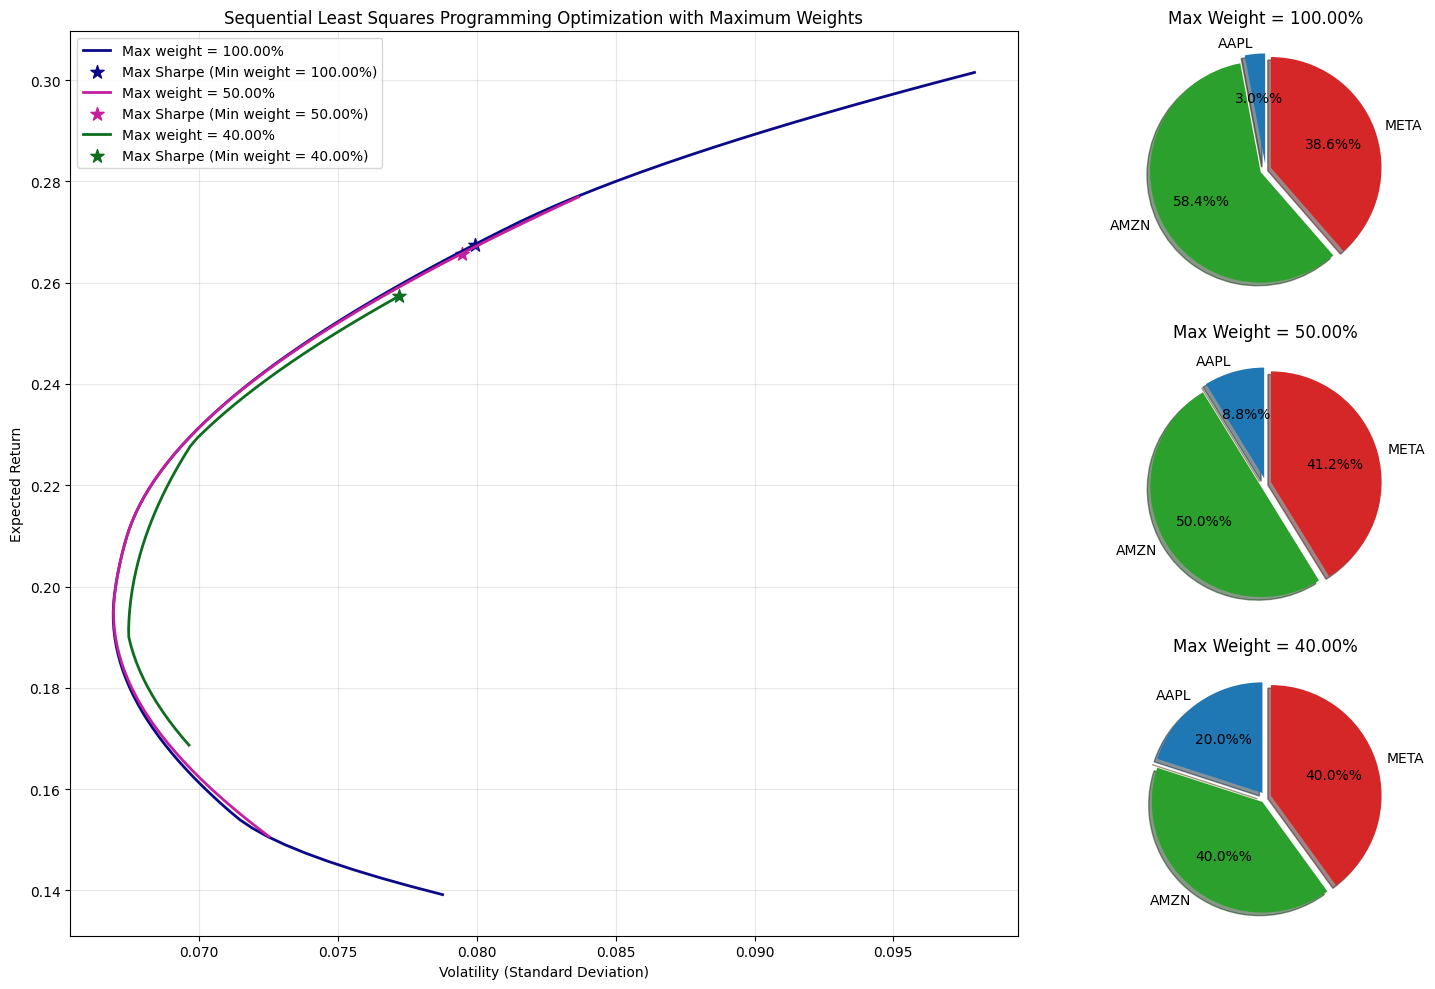

In [8]:
# Minimizing volatility
import src.optimizer
importlib.reload(src.optimizer)
from src.optimizer import portfolio_minimize
from src.optimizer import portfolio_maximize_sharpe

desired_returns = np.linspace(returns_random.min(), returns_random.max(), 100)
volatilities_SM_var = []
returns_SM_sharpe = []
volatilities_SM_sharpe = []
weights_sharpe_list = []

max_weights = [1.0, 0.5, 0.4]

print("\n=== COMPARISON OF MAXIMUM WEIGHT CONSTRAINTS ===")

for i, max_weight in enumerate(max_weights):

    portfolio_SM_var = []
    for r in desired_returns:
        result_SM_var = portfolio_minimize(annualized_mean_returns, annualized_covariance, r, max_weight = max_weight)
        weights_SM_var = result_SM_var.x

        volatility_SM_var = np.sqrt(np.dot(weights_SM_var.T, (np.dot(annualized_covariance, weights_SM_var))))

        # If optimization succeeded, add the volatility to our list
        if result_SM_var['success']:
            portfolio_SM_var.append((r, volatility_SM_var))
        else:
            # If optimization failed, use NaN to indicate a gap in the frontier
            portfolio_SM_var.append((r, np.nan))
        
    r, volatility_SM_var = zip(*portfolio_SM_var)

    # Maximizing Sharpe-ratio
    result_SM_sharpe = portfolio_maximize_sharpe(annualized_mean_returns, annualized_covariance, risk_free_rate, max_weight = max_weight)
    weights_SM_sharpe = result_SM_sharpe.x
    weights_sharpe_list.append(weights_SM_sharpe)

    return_SM_sharpe = weights_SM_sharpe @ annualized_mean_returns
    volatility_SM_sharpe = np.sqrt(np.dot(weights_SM_sharpe.T, (np.dot(annualized_covariance, weights_SM_sharpe))))

    # Append returns and volatilties to lists for later use when comparing
    if i == 0:
        volatilities_SM_var = [volatility_SM_var]
    else:
        volatilities_SM_var.append(volatility_SM_var)
    volatilities_SM_sharpe.append(volatility_SM_sharpe)
    returns_SM_sharpe.append(return_SM_sharpe)


    # Compare the results
    sharpe_ratio = (returns_SM_sharpe[i] - risk_free_rate) / volatilities_SM_sharpe[i]
    print(f"\nMaximum Weight: {max_weight:.2%}")
    print(f"  Max Sharpe Ratio Portfolio:")
    print(f"    Return = {returns_SM_sharpe[i]*100:.2f}%")
    print(f"    Volatility = {volatilities_SM_sharpe[i]*100:.2f}%")
    print(f"    Sharpe Ratio = {sharpe_ratio:.2f}")
        
# Plotting the results
fig = plt.figure(figsize=(20,10))
gs = gridspec.GridSpec(3, 4, figure = fig) # 3 rows, 4 columns

ax_big = fig.add_subplot(gs[:, :2])  # Big plot for efficient frontier
ax1 = fig.add_subplot(gs[0, 2])  # First subplot for min weight
ax2 = fig.add_subplot(gs[1, 2])  # Second subplot for min weight
ax3 = fig.add_subplot(gs[2, 2])  # Third subplot for min weight


colors = ['#0A0A88', "#C51F9E", "#0E6E1F"]  # Different colors for each min weight
for i in range(3):
    ax_big.plot(volatilities_SM_var[i], r, label=f"Max weight = {max_weights[i]:.2%}", linewidth=2, color=colors[i])
    ax_big.scatter(volatilities_SM_sharpe[i], returns_SM_sharpe[i], 
                color = colors[i], marker='*', s=100, label=f"Max Sharpe (Min weight = {max_weights[i]:.2%})")

    ax_big.set_xlabel('Volatility (Standard Deviation)')
    ax_big.set_ylabel('Expected Return')
    ax_big.set_title("Sequential Least Squares Programming Optimization with Maximum Weights")
    ax_big.legend()
    ax_big.grid(True, alpha=0.3)
# Create a better color palette
colors = plt.cm.tab10(np.arange(len(tickers)) % 10)

# Function to create labels that hide names for weights < 1%
def create_labels(weights, tickers):
    labels = []
    for i, (weight, ticker) in enumerate(zip(weights, tickers)):
        if weight >= 0.01:  # 1% threshold
            labels.append(ticker)
        else:
            labels.append('')  # Empty label for small weights
    return labels

# Function to create percentage labels that hide percentages for weights < 1%
def create_autopct(weights):
    def autopct_func(pct):
        # Find the corresponding weight for this percentage
        weight = pct / 100.0
        if weight >= 0.01:  # 1% threshold
            return f'{pct:.1f}%%'
        else:
            return ''  # Empty percentage for small weights
    return autopct_func

# Create pie charts for each maximum weight constraint
labels_0 = create_labels(weights_sharpe_list[0], tickers)
ax1.pie(weights_sharpe_list[0], labels=labels_0, autopct=create_autopct(weights_sharpe_list[0]), 
        startangle=90, colors=colors, shadow=True, explode=[0.05]*len(tickers))
ax1.set_title(f'Max Weight = {max_weights[0]:.2%}')

labels_1 = create_labels(weights_sharpe_list[1], tickers)
ax2.pie(weights_sharpe_list[1], labels=labels_1, autopct=create_autopct(weights_sharpe_list[1]), 
        startangle=90, colors=colors, shadow=True, explode=[0.05]*len(tickers))
ax2.set_title(f'Max Weight = {max_weights[1]:.2%}')

labels_2 = create_labels(weights_sharpe_list[2], tickers)
ax3.pie(weights_sharpe_list[2], labels=labels_2, autopct=create_autopct(weights_sharpe_list[2]), 
        startangle=90, colors=colors, shadow=True, explode=[0.05]*len(tickers))
ax3.set_title(f'Max Weight = {max_weights[2]:.2%}')
plt.tight_layout()
plt.show()

While increasing minimum weights forces the optimizer to include more assets — shrinking the efficient frontier both vertically and horizontally — maximum weight constraints behave differently.

As we lower the maximum allowed weight (e.g. from 100% to 40%), the efficient frontier becomes shorter vertically, but does not shift significantly to the right on the risk axis. In other words:
- We lose some access to high-return portfolios,
- But the volatility range stays relatively stable.

This suggests that while the optimizer can't fully concentrate in a few top-performing assets, it can still maintain similar risk levels by balancing exposures more evenly. The result is reduced return potential but without a dramatic increase in overall portfolio risk.

This contrasts with minimum weight constraints, which not only reduce return potential, but also push the entire frontier toward higher volatility due to forced inclusion of potentially lower-return assets.